## Installation

In [1]:
# %pip install ai-economist
# %pip install gym==0.21
# %pip install tensorflow==2.5.0 numpy==1.21.1
# %pip install "ray[rllib]==0.8.4"
# %pip install protobuf==3.20.3 scipy==1.8

## Define Environment

In [2]:
import os, sys
os.chdir(os.path.dirname(os.path.abspath("__file__")))

from ai_economist import foundation

import numpy as np
import matplotlib.pyplot as plt
from tutorials.rllib.env_wrapper import RLlibEnvWrapper

Inside covid19_components.py: 1 GPUs are available.


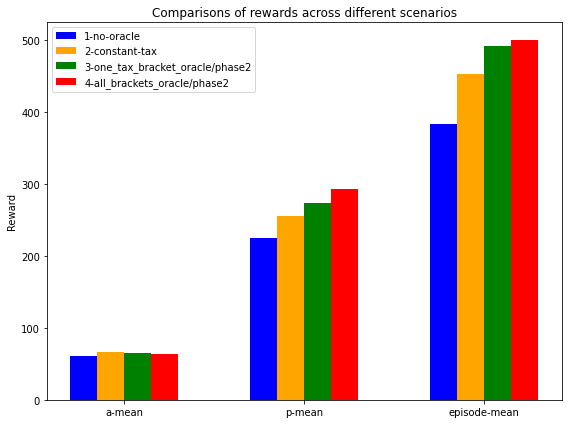

In [3]:
labels = ['a-mean', 'p-mean', 'episode-mean']
senarios = ['1-no-oracle', '2-constant-tax', '3-one_tax_bracket_oracle/phase2', '4-all_brackets_oracle/phase2']
a_mean = [61.2, 66.8, 65.51, 64.03]
p_mean = [224.29, 254.915, 273.72, 292.8]
episode_mean = [383.86, 452.54, 491.41, 499.70]

data = [a_mean, p_mean, episode_mean]
colors = ['blue', 'orange', 'green', 'red']
x = np.arange(len(labels))

# Bar width
width = 0.15

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(senarios)):
    ax.bar(x + i * width, 
           [data[j][i] for j in range(len(labels))], 
           width, label=senarios[i], color=colors[i])

# ax.set_xlabel('Metrics')
ax.set_ylabel('Reward')
ax.set_title('Comparisons of rewards across different scenarios')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
# plt.savefig('compare.png')
# plt.show()

In [4]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

In [5]:
# Define a configuration (dictionary) for the "gather-trade-build" environment.

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # the class's name in the Scenario Registry (foundation.scenarios).
    'scenario_name': 'layout_from_file/hetero_agents',
    
    # ===== COMPONENTS =====
    # list of ("component_name", {component_kwargs}) tuples
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # (The order in which components reset, step, and generate obs follows their listed order below)
    'components': [
        # (1) Building houses
        ('Build', {
            'skill_dist':                   'pareto', 
            'payment_max_skill_multiplier': 3,
            'build_labor':                  10,
            'payment':                      10
        }),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', {
            'max_bid_ask':    10,
            'order_labor':    0.25,
            'max_num_orders': 5,
            'order_duration': 50
        }),
        # (3) Movement and resource collection
        ('Gather', {
            'move_labor':    1,
            'collect_labor': 1,
            'skill_dist':    'pareto'
        }),
        # (4) Planner
        ('PeriodicBracketTax', {
            'period':          250,
            # 'tax_model':       'us-federal-single-filer-2018-scaled',
            'bracket_spacing': 'us-federal',
            'usd_scaling':     1000,
            'n_brackets':      3,
            'disable_taxes':   False,
        })
    ],
    
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'env_layout_file': 'quadrant_25x25_20each_30clump.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 3,          # Number of non-planner agents (must be > 1)
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 750, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': True,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    
    # How often to save the dense logs
    'dense_log_frequency': 1,
    
    # new
    "env_weighting" :[0.002, 0.001, -0.001],#needs to have len of n agents
    "equ_weighting": [-0.04, 0.01, 0.08],
    "mobile_agent_class": "HeteroMobileAgent",# BasicMobileAgent
    
}

In [6]:
# Test env settings
env = foundation.make_env_instance(**env_config_dict)
obs = env.reset()
for agent in env.world.agents:
    print('[Agent {}]\ncoin-per-house: {}\nenvironment weight: {}\nequality weight: {}\n'.format(
        agent.idx, agent.state['build_payment'], agent.env_weighting, agent.equality
        ))

[Agent 0]
coin-per-house: 11.81445367502974
environment weight: 0.002
equality weight: -0.04

[Agent 1]
coin-per-house: 14.87301326696934
environment weight: 0.001
equality weight: 0.01

[Agent 2]
coin-per-house: 20.79461173785582
environment weight: -0.001
equality weight: 0.08



### Observation spaces
* one-dimensional features (e.g. `action-mask`, `flat`, `time`)
* spatial features (e.g., `world-idx-map`, `world-map`)

- An `action_mask` is used to mask out the actions that are not allowed by the environment. For instance, a mobile agent cannot move beyond the boundary of the world. Hence, in position (0, 0), a mobile cannot move "Left" or "Down", and the corresponding actions in the mask would be nulled out. Now, the RL agent can still recommend to move "Left" or "Down", but the action isn't really taken.
- The key `flat` arises since we set `flatten_observations': True`. Accordingly, the scalar and vector raw observations are all concatenated into this single key. If you're curious to see the entire set of raw observations, do set `flatten_observations': False` in the env_config, and re-run the above cell.

### Action spaces
The mobile agents can take 50 possible actions 
* 1 NO-OP action or do nothing (always indexed 0)
* 44 trading-related actions
* 4 move actions along the four directions
* 1 build action

The planner sets the tax rates for 7 brackets, each `MultiDiscrete([22 22 22 22 22 22 22])`
* from 0-100% in steps of 5% - 21 values
* NO-OP action

In [7]:
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (50,)
flat           : (135,)
time           : (1,)
world-idx_map  : (2, 11, 11)
world-map      : (7, 11, 11)


[EnvWrapper] Obs (p)   
action_mask    : (154,)
flat           : (85,)
p0             : (8,)
p1             : (8,)
p2             : (8,)
time           : (1,)
world-idx_map  : (2, 25, 25)
world-map      : (6, 25, 25)


[EnvWrapper] Action (a) Discrete(50)
[EnvWrapper] Action (p) MultiDiscrete([22 22 22 22 22 22 22])


In [8]:
# set `policies`, `policy_mapping_fun` and `policies_to_train`
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}
# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"
policies_to_train = ["a", "p"]

# Create a multiagent trainer config holding the trainable policies and their mappings.
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

## Define Training Object

In [9]:
# Initialize Ray
ray.init(webui_host="127.0.0.1")

2024-05-27 05:12:53,553	INFO resource_spec.py:204 -- Starting Ray with 6.49 GiB memory available for workers and up to 3.26 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2024-05-27 05:12:53,932	INFO services.py:1146 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '192.168.0.125',
 'redis_address': '192.168.0.125:54925',
 'object_store_address': '/tmp/ray/session_2024-05-27_05-12-53_549224_173813/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2024-05-27_05-12-53_549224_173813/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2024-05-27_05-12-53_549224_173813'}

[PPO settings](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#ppo)

[DQN Settings](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#dqn)

In [10]:
trainer_config.update(
    {
        "num_workers": 6,
        "num_envs_per_worker": 2,
        # common settings
        "train_batch_size":  4000,
        # settings for PPO
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1,
        # settings for DQN
        # "tau": 0.8,
        # "n_step": 1000,
    }
)

# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
    # log_level='INFO',
    )

# # Create the DQN trainer.
# trainer = DQNTrainer(
#     env=RLlibEnvWrapper,
#     config=trainer_config,
#     )

2024-05-27 05:12:54,114	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2024-05-27 05:12:54,334	INFO trainer.py:583 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=173931) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
(pid=173931)   logger.warn("Overriding environment {}".format(id))
(pid=173931) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
(pid=173931)   logger.warn("Overriding environment {}".format(id))
(pid=173931) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment Adventure-v0
(pid=173931)   logger.warn("Overriding environment {}".format(id))
(pid=173931) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment AdventureDeterministic-v0
(pid=173931)   logger.warn("Overriding environment {}".format(id))
(pid=173931) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-package

2024-05-27 05:13:01,197	WARNING worker.py:969 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.



(pid=173925) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment HeroNoFrameskip-v0
(pid=173925)   logger.warn("Overriding environment {}".format(id))
(pid=173925) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment Hero-v4
(pid=173925)   logger.warn("Overriding environment {}".format(id))
(pid=173925) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment HeroDeterministic-v4
(pid=173925)   logger.warn("Overriding environment {}".format(id))
(pid=173925) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment HeroNoFrameskip-v4
(pid=173925)   logger.warn("Overriding environment {}".format(id))
(pid=173925) /home/zilong/Disk_sda6/env-AIecon/lib/python3.8/site-packages/g

2024-05-27 05:13:09,271	INFO trainable.py:177 -- _setup took 14.940 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-05-27 05:13:09,272	INFO trainable.py:217 -- Getting current IP.


## Training

********** Iter : 0 **********
episode_reward_mean: nan
********** Iter : 1 **********
episode_reward_mean: 28.45556275835018
********** Iter : 2 **********
episode_reward_mean: 24.48690750687547
********** Iter : 3 **********
episode_reward_mean: 27.590203166585304
********** Iter : 4 **********
episode_reward_mean: 26.036704610640975
********** Iter : 5 **********
episode_reward_mean: 22.519012261736133
********** Iter : 6 **********
episode_reward_mean: 24.59499672634396
********** Iter : 7 **********
episode_reward_mean: 22.44181026673129
********** Iter : 8 **********
episode_reward_mean: 25.975365159421028
********** Iter : 9 **********
episode_reward_mean: 26.731301964674053
********** Iter : 10 **********
episode_reward_mean: 27.209775706238904
********** Iter : 11 **********
episode_reward_mean: 28.222830195713463
********** Iter : 12 **********
episode_reward_mean: 28.920721832672488
********** Iter : 13 **********
episode_reward_mean: 28.042790496328436
********** Iter : 14 

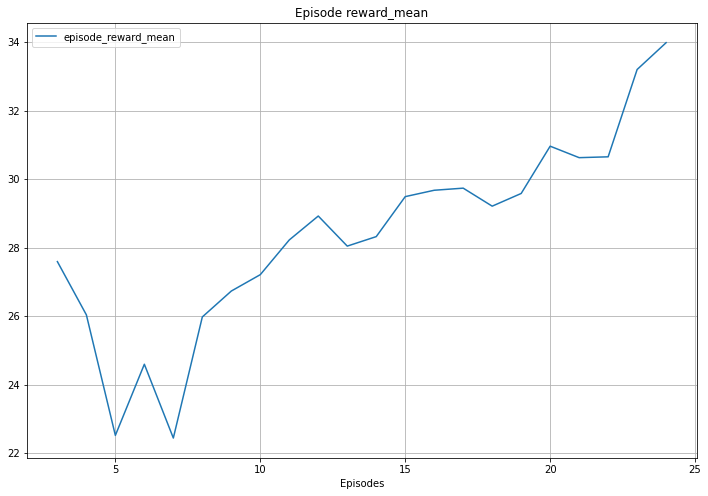

In [11]:
WARM_UP_ITERS = 3
NUM_ITERS = 25
episode_reward_log = []
for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    result = trainer.train()
    episode_reward_mean = result.get('episode_reward_mean')
    episode_reward_log.append(episode_reward_mean)
    print(f'''episode_reward_mean: {episode_reward_mean}''')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(list(range(WARM_UP_ITERS,NUM_ITERS)), episode_reward_log[WARM_UP_ITERS:NUM_ITERS], label='episode_reward_mean')
ax.set_title("Episode reward_mean")
ax.set_xlabel('Episodes')
ax.legend()
ax.grid(b=True)
plt.show()
# plt.savefig("episode_reward_mean.png")

## Retrieve Dense Log

In [12]:
def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], planner_states, policy_id='p', full_fetch=False
            )

            obs, rew, done, info = env_obj.step(actions)        
            if done['__all__']:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

In [13]:
# create N random intialized rollout samples from current trainer policy
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, env_obj, num_dense_logs=1
)

In [14]:
# Shutdown Ray after use
ray.shutdown()

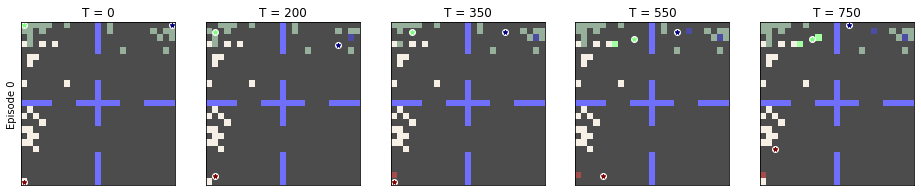

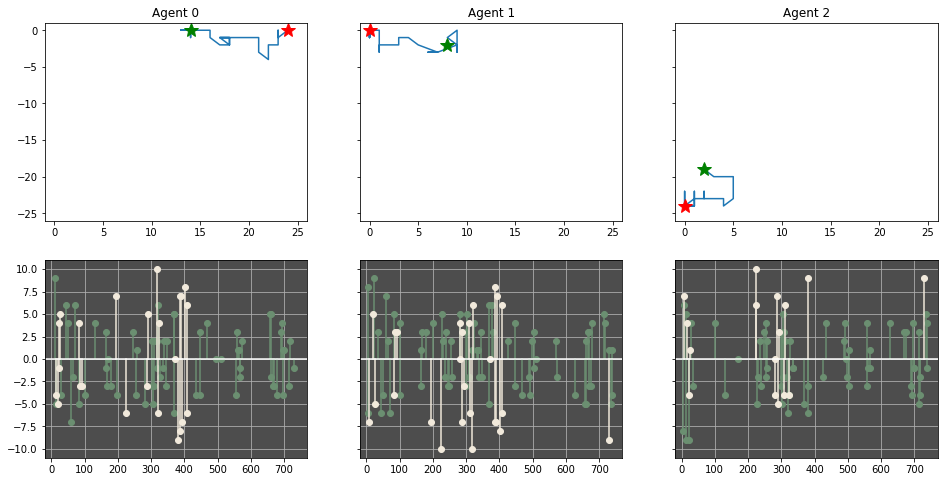

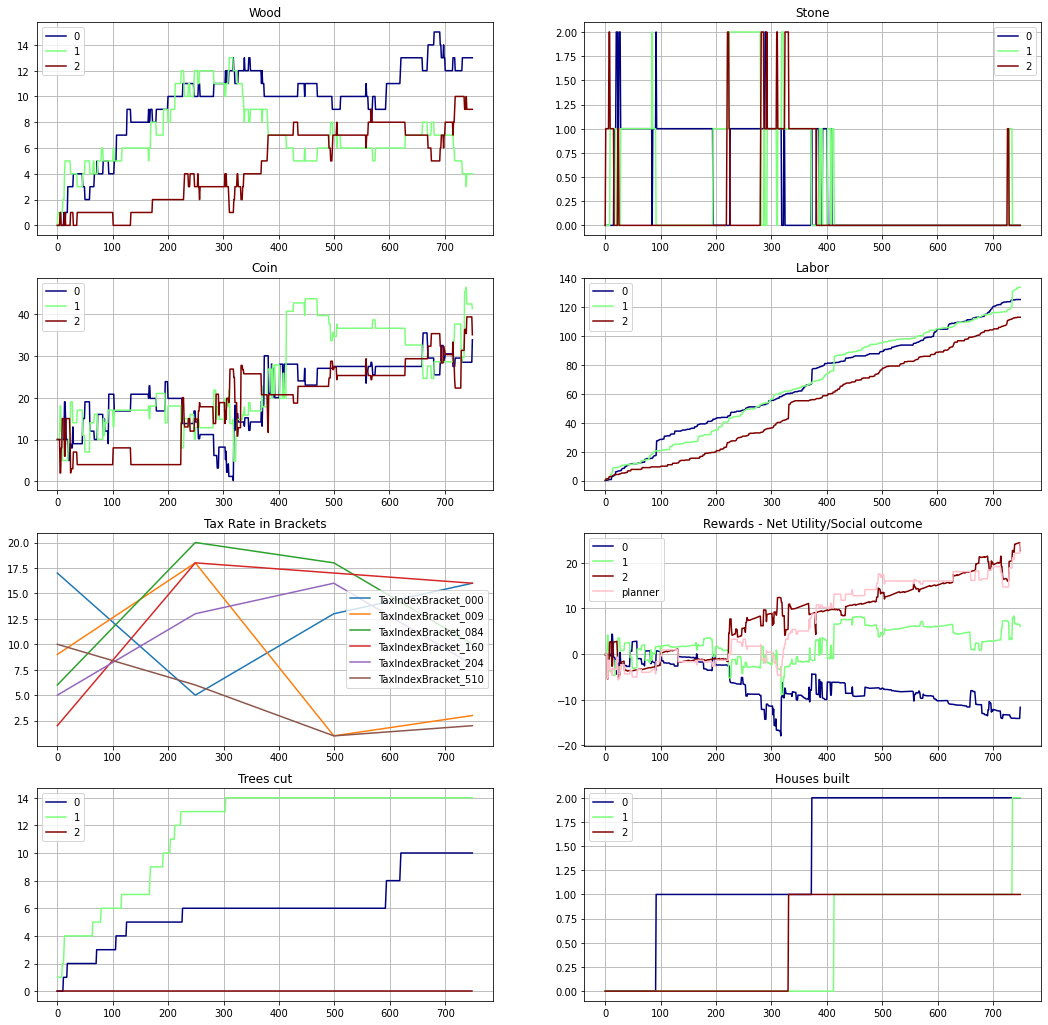

In [15]:
from tutorials.utils import plot_new
# # For 4a: log from the workers' environment objects
# dense_log_idx = f"worker={1};env_id={1}"
# dense_log_vis = dense_logs[dense_log_idx]

# For 4b: log generated from the most recent trainer policy model weights
dense_log_idx = 0
dense_log_vis = dense_logs[dense_log_idx]

# print(len(dense_log_vis['Build']))
# print(dense_log_vis['Gather'][0][0])
# print(dense_log_vis['world'][-2])
# # print(dense_log_vis['states'][0]['0']['inventory'].keys())
# print(dense_log_vis["actions"][0]['p'].keys())

# print(dense_log_vis["actions"][10]['p'])
# print(dense_log_vis["rewards"][10])

# print(f"Env coefficent: ", env_config_dict['env_weighting'])
# print(f"Equality coefficent: ", env_config_dict['equ_weighting'])

# show
(fig0, fig1, fig2), incomes, endows, c_trades, all_builds = plot_new.breakdown(dense_log_vis)

fig2.savefig('vis.png')